In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')

In [14]:
genres_item_matrix = pd.read_csv('data/genres_item_matrix.csv', index_col='id')
tag_item_matrix = pd.read_csv('data/tag_item_matrix.csv', index_col='id')
title_df = pd.read_csv('data/title_df.csv', index_col='id')

In [16]:
# We'll use this dataframe later for lookup
title_df.head()

,romaji,english,native,userPreferred
id,,,,
10161,No.6,No.6,NO.6 ナンバー・シックス,No.6
99726,Net-juu no Susume,Recovery of an MMO Junkie,ネト充のススメ,Net-juu no Susume
98526,Robomasters The Animated Series,NaN,ROBOMASTERS THE ANIMATED SERIES,Robomasters The Animated Series
966,Crayon Shin-chan,Shin Chan,クレヨンしんちゃん,Crayon Shin-chan
4876,Hashire Melos!,Run Melos!,走れメロス,Hashire Melos!


In [6]:
genres_item_matrix.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,mystery,psychological,romance,sci_fi,slice_of_life,sports,supernatural,thriller
id,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
99726,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0
98526,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
966,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4876,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
tag_item_matrix.head()

,4_koma,achronological_order,acting,advertisement,afterlife,age_gap,age_regression,agender,airsoft,aliens,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99726,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98526,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
966,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4876,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df = pd.concat([genres_item_matrix, tag_item_matrix], axis=1)
df.head()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
10161,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99726,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98526,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
966,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4876,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
df.tail()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
id,,,,,,,,,,,,,,,,,,,,,
99586,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99916,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
101283,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101633,0,0,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
101089,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9832 entries, 10161 to 101089
Columns: 259 entries, action to zombie
dtypes: int64(259)
memory usage: 19.5 MB


In [12]:
df.describe()

,action,adventure,comedy,drama,ecchi,fantasy,horror,mahou_shoujo,mecha,music,...,witch,work,wrestling,writing,wuxia,yakuza,yandere,youkai,yuri,zombie
count,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,...,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000,9832.000000
mean,0.268002,0.213283,0.391172,0.190704,0.062449,0.198841,0.034886,0.025325,0.082994,0.097539,...,0.004780,0.011290,0.001322,0.001221,0.000203,0.001424,0.001729,0.007425,0.011290,0.003153
std,0.442941,0.409647,0.488038,0.392876,0.241982,0.399148,0.183501,0.157120,0.275888,0.297048,...,0.068978,0.105657,0.036340,0.034916,0.014262,0.037710,0.041548,0.085851,0.105657,0.056066
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
total_per_feature = df.sum(axis=0)
total_per_feature

action       2635
adventure    2097
comedy       3846
drama        1875
ecchi         614
             ... 
yakuza         14
yandere        17
youkai         73
yuri          111
zombie         31
Length: 259, dtype: int64

In [20]:
total_per_show = df.sum(axis=1)
total_per_show

id
10161      7
99726     11
98526      4
966        8
4876       8
          ..
99586      7
99916      7
101283    13
101633     7
101089     1
Length: 9832, dtype: int64

In [27]:
total_per_show.rename('total_features_per_show')

id
10161      7
99726     11
98526      4
966        8
4876       8
          ..
99586      7
99916      7
101283    13
101633     7
101089     1
Name: total_features_per_show, Length: 9832, dtype: int64

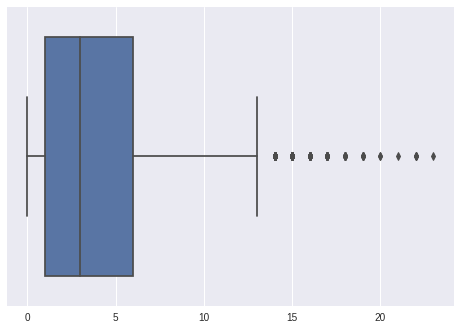

In [28]:
sns.boxplot(total_per_show);

This seems potentially problematic. A majority of the shows don't have very many features. How many are needed to make an acurate recommendation?

In [41]:
print('{0:.1%}'.format(len(total_per_show[total_per_show < 3]) / len(total_per_show)), 
      'or', len(total_per_show[total_per_show < 3]), 'shows have 2 or fewer features describing them.')


43.3% or 4259 shows have 2 or fewer features describing them.


In [43]:
print('{0:.1%}'.format(len(total_per_show[total_per_show < 6]) / len(total_per_show)), 
      'or', len(total_per_show[total_per_show < 6]), 'shows have 5 or fewer features describing them.')


74.8% or 7359 shows have 5 or fewer features describing them.


While selecting which tags to keep, many were cut out because of a low "rank" score. Let's go back and keep all tags but normalize(standardize?) them. 